# Analyze ULRs tweeted by US politicians

In [2]:
import pandas as pd
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import itertools
import seaborn as sns
from matplotlib.gridspec import GridSpec

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

import sys
sys.path.append('../../../../utilities/twitter_functions')
import twitter_functions as tf

In [3]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"

ax_label_fontsize = 16
leg_label_fontsize = 14

## Massage data

In [ ]:
src = "../../data/twitter"
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_clean.csv.gzip"
df = pd.read_csv(join(src, fname),
                 compression="gzip",
                 usecols=["id", "author_id", "created_at", "expanded_urls",
                          "retweeted", "quoted", "reply"])
df = df.drop_duplicates(subset="id")

In [108]:
df["expanded_urls"] = df["expanded_urls"].fillna("[]")
df["expanded_urls"] = df["expanded_urls"].apply(lambda x: eval(x))
df["has_url"] = df["expanded_urls"].apply(lambda x: len(x) > 0)

In [109]:
# expand the url lists into individual columns
urls = df['expanded_urls']\
    .apply(pd.Series)\
    .reset_index()\
    .melt(id_vars='index')\
    .dropna()[['index', 'value']]\
    .set_index('index')

In [110]:
urls = pd.merge(
    urls,
    df[['id']],
    left_index=True,
    right_index=True).rename(columns={'value_x': 'expanded_urls'})

df = pd.merge(df, urls, left_on="id", right_on="id", how="left")

df["N_urls"] = df["expanded_urls"].apply(lambda x: len(x))
df = df.rename(columns={"value":"url"})

df.to_csv(join(src, "combined_US_politician_twitter_timelines_2010-11-06_to_2021-03-16_clean_urls.csv.xz"),
          compression="xz", index=False)

## Import unraveled URLs

Note: run the following to unravel a list of URLs:  
`python ../../../utilities/unravel_urls/unravel_urls.py url_list.csv.gzip -dst unraveled_urls3/ -v 1`

In [4]:
src = "../../data/twitter"
df = pd.read_csv(join(src, "combined_US_politician_twitter_timelines_2010-11-06_to_2021-03-16_clean_urls.csv.xz"),
          compression="xz")
df["id"] = df["id"].apply(lambda x: x.replace('"', ''))
df["author_id"] = df["author_id"].apply(lambda x: x.replace('"', ''))

In [5]:
unraveled_urls = pd.read_csv(join(src, "unraveled_urls.csv.xz"),
                             compression="xz")

In [6]:
# split into a table with and a table without URLs
no_urls = df[df["has_url"] == False].copy()
df = df[df["has_url"] == True]

In [7]:
# add URL information
df = pd.merge(df, unraveled_urls, left_on="url", right_on="url", how="left")

# add indicator of whether the URL was originally shortened
df["shortened"] = False
df.loc[df["unraveled_url"].dropna().index, "shortened"] = True

# replace the shortened URL with the unraveled URL
df.loc[df["unraveled_url"].dropna().index, "url"] = \
    df.loc[df["unraveled_url"].dropna().index, "unraveled_url"]
df = df.drop(columns=["unraveled_url"])

In [8]:
# extract the domain from the URL
df["domain"] = df["url"].apply(tf.extract_domain)

found malformed URL https
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http


## Find fishy domains with newsguard data

Newsguard rating cutoff: 60 (see [description](https://www.newsguardtech.com/ratings/rating-process-criteria/)).

In [10]:
newsguard_score_cutoff = 60
newsguard_src = "../../data/newsguard/newsguard_2022-03/03"
nutrition_labels = pd.read_csv(join(newsguard_src, "metadata-2022030100.csv"))

nutrition_labels = nutrition_labels\
    .sort_values(by=["Domain", "Last Updated"], ascending=False)
nutrition_labels = nutrition_labels.drop_duplicates(subset=["Domain"])

# threshold scores to create a "fishy" label
nutrition_labels["fishy"] = 0
nutrition_labels["fishy_40"] = 0
nutrition_labels["fishy_20"] = 0
nutrition_labels.loc[nutrition_labels[nutrition_labels["Score"] < newsguard_score_cutoff].index, "fishy"] = 1
fishy_domains = set(nutrition_labels[nutrition_labels["fishy"] == 1]["Domain"])
nutrition_labels.loc[nutrition_labels[nutrition_labels["Score"] < 40].index, "fishy_40"] = 1
fishy_40_domains = set(nutrition_labels[nutrition_labels["fishy_40"] == 1]["Domain"])
nutrition_labels.loc[nutrition_labels[nutrition_labels["Score"] < 20].index, "fishy_20"] = 1
fishy_20_domains = set(nutrition_labels[nutrition_labels["fishy_20"] == 1]["Domain"])

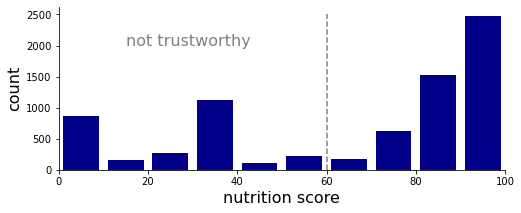

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(nutrition_labels["Score"], rwidth=0.8, color="DarkBlue")
ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("count", fontsize=16)
ax.set_xlabel("nutrition score", fontsize=16)
ax.plot([60, 60], [0, 2500], '--', color="grey")
ax.text(15, 2000, "not trustworthy", color="grey", fontsize=16)
plt.savefig("../../plots/newsguard_scores.svg",
            bbox_inches="tight")

In [12]:
nutrition_cols = [
    "fishy", "fishy_40", "fishy_20", "Domain",
    "Rating", "Score", "Country", "Language", 
    "Does not repeatedly publish false content",
    "Gathers and presents information responsibly",
    "Regularly corrects or clarifies errors",
    "Handles the difference between news and opinion responsibly",
    "Avoids deceptive headlines",
    "Website discloses ownership and financing",
    "Clearly labels advertising",
    "Reveals who's in charge, including any possible conflicts of interest",
    "The site provides names of content creators, along with either contact or biographical information"
]
nutrition_categories = {col:f"C_{i}" for i, col in enumerate(nutrition_cols[8:])}

In [13]:
nut_cat_dict = {
    "fishy": "domains with a NewsGuard\nscore of < 60",
    "fishy_40": "domains with a NewsGuard\nscore of < 40",
    "fishy_20":"domains with a NewsGuard\nscore of < 20",
    "C_0":"repeatedly publishes false information",
    "C_1":"doesn't gather and present\ninformation responsibly",
    "C_2":"doesn't regularly correct\nor clarify errors",
    "C_3":"doesn't handle the difference\nbetween news and opinion responsibly",
    "C_4":"uses deceptive headlines",
    "C_5":"doesn't disclose website\nownership and financing",
    "C_6":"doesn't label advertising",
    "C_7":"doesn't reveal conflicts\nof interest and who is in charge",
    "C_8":"doesn't provide names and\nbios of content creators"
}

In [14]:
# add the nutrition information to the tweets
df = pd.merge(df, nutrition_labels[nutrition_cols],
         left_on="domain", right_on="Domain", how="left")

df = df.rename(columns=nutrition_categories)

# clean up the labels
for col in nutrition_categories.values():
    df[col] = df[col].replace({"Yes":0, "No":1})

In [135]:
#url_export = df[["url", "Score"]].copy()
#url_export = url_export.drop_duplicates()
#url_export[["url", "Score"]]\
#    .rename(columns={"Score":"score"})\
#    .to_csv(join(src, "unraveled_url_list.csv.gzip"), index=False, compression="gzip")

## Count fishy domains in politician Tweets

In [15]:
N_shortened = len(df[(df["shortened"] == True)])
N_shortened_fishy = len(df[(df["shortened"] == True) & (df["fishy"] == 1)])
print("{}/{} ({:1.2f}%) shortened domains are fishy"\
      .format(N_shortened_fishy, N_shortened, 
              (N_shortened_fishy / N_shortened) * 100))

N_unshortened = len(df[(df["shortened"] == False)])
N_unshortened_fishy = len(df[(df["shortened"] == False) & (df["fishy"] == 1)])
print("{}/{} ({:1.2f}%) unshortened domains are fishy"\
      .format(N_unshortened_fishy, N_unshortened, 
              (N_unshortened_fishy / N_unshortened) * 100))

print("{}/{} ({:1.2f}%) of links are shortened"\
      .format(N_shortened, N_shortened + N_unshortened,
              (N_shortened / (N_shortened + N_unshortened)) * 100))

1378/184223 (0.75%) shortened domains are fishy
5503/1706510 (0.32%) unshortened domains are fishy
184223/1890733 (9.74%) of links are shortened


In [16]:
N_shortened = len(df[(df["shortened"] == True)])
N_shortened_fishy = len(df[(df["shortened"] == True) & (df["fishy_40"] == 1)])
print("{}/{} ({:1.2f}%) shortened domains are fishy (40)"\
      .format(N_shortened_fishy, N_shortened, 
              (N_shortened_fishy / N_shortened) * 100))

N_unshortened = len(df[(df["shortened"] == False)])
N_unshortened_fishy = len(df[(df["shortened"] == False) & (df["fishy_40"] == 1)])
print("{}/{} ({:1.2f}%) unshortened domains are fishy (40)"\
      .format(N_unshortened_fishy, N_unshortened, 
              (N_unshortened_fishy / N_unshortened) * 100))

print("{}/{} ({:1.2f}%) of links are shortened"\
      .format(N_shortened, N_shortened + N_unshortened,
              (N_shortened / (N_shortened + N_unshortened)) * 100))

556/184223 (0.30%) shortened domains are fishy (40)
2215/1706510 (0.13%) unshortened domains are fishy (40)
184223/1890733 (9.74%) of links are shortened


In [17]:
N_shortened = len(df[(df["shortened"] == True)])
N_shortened_fishy = len(df[(df["shortened"] == True) & (df["fishy_20"] == 1)])
print("{}/{} ({:1.2f}%) shortened domains are fishy (20)"\
      .format(N_shortened_fishy, N_shortened, 
              (N_shortened_fishy / N_shortened) * 100))

N_unshortened = len(df[(df["shortened"] == False)])
N_unshortened_fishy = len(df[(df["shortened"] == False) & (df["fishy_20"] == 1)])
print("{}/{} ({:1.2f}%) unshortened domains are fishy (20)"\
      .format(N_unshortened_fishy, N_unshortened, 
              (N_unshortened_fishy / N_unshortened) * 100))

print("{}/{} ({:1.2f}%) of links are shortened"\
      .format(N_shortened, N_shortened + N_unshortened,
              (N_shortened / (N_shortened + N_unshortened)) * 100))

137/184223 (0.07%) shortened domains are fishy (20)
1023/1706510 (0.06%) unshortened domains are fishy (20)
184223/1890733 (9.74%) of links are shortened


In [18]:
# put the tweets with and without URLs back together
no_urls["shortened"] = False
no_urls["domain"] = np.nan
no_urls["fishy"] = 0
no_urls["fishy_40"] = 0
no_urls["fishy_20"] = 0
for col in nutrition_categories.values():
    no_urls[col] = 0
no_urls["Domain"] = np.nan
no_urls["Rating"] = np.nan
no_urls["Score"] = np.nan
no_urls["Language"] = np.nan
no_urls["Country"] = np.nan

all_tweets = pd.concat([df, no_urls])
del df
del no_urls

In [19]:
fishy_tweet_count = all_tweets[["id", "fishy", "fishy_40", "fishy_20"] + list(nutrition_categories.values())]\
    .groupby("id")\
    .sum()
fishy_tweet_count.head(2)

,fishy,fishy_40,fishy_20,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8
id,,,,,,,,,,,,
1000000245584072704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000001121384050690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
N_tweets = len(fishy_tweet_count)
N_fishy_tweets = len(fishy_tweet_count[fishy_tweet_count["fishy"] > 0])
print("{}/{} ({:1.3f}%) tweets contain fishy urls"\
      .format(N_fishy_tweets, N_tweets, (N_fishy_tweets / N_tweets) * 100))

N_fishy_40_tweets = len(fishy_tweet_count[fishy_tweet_count["fishy_40"] > 0])
print("{}/{} ({:1.3f}%) tweets contain fishy (40) urls"\
      .format(N_fishy_tweets, N_tweets, (N_fishy_40_tweets / N_tweets) * 100))

N_fishy_20_tweets = len(fishy_tweet_count[fishy_tweet_count["fishy_20"] > 0])
print("{}/{} ({:1.3f}%) tweets contain fishy (20) urls"\
      .format(N_fishy_tweets, N_tweets, (N_fishy_20_tweets / N_tweets) * 100))

N_C_0_tweets = len(fishy_tweet_count[fishy_tweet_count["C_0"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that repeatedly publishe false content"\
      .format(N_C_0_tweets, N_tweets, (N_C_0_tweets / N_tweets) * 100))

N_C_1_tweets = len(fishy_tweet_count[fishy_tweet_count["C_1"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not represent information responsibly"\
      .format(N_C_1_tweets, N_tweets, (N_C_1_tweets / N_tweets) * 100))

N_C_2_tweets = len(fishy_tweet_count[fishy_tweet_count["C_2"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not correct or clarify errors"\
      .format(N_C_2_tweets, N_tweets, (N_C_2_tweets / N_tweets) * 100))

N_C_3_tweets = len(fishy_tweet_count[fishy_tweet_count["C_3"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not handle differences between news and opinion responsibly"\
      .format(N_C_3_tweets, N_tweets, (N_C_3_tweets / N_tweets) * 100))

N_C_4_tweets = len(fishy_tweet_count[fishy_tweet_count["C_4"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that use deceptive headlines"\
      .format(N_C_4_tweets, N_tweets, (N_C_4_tweets / N_tweets) * 100))

N_C_5_tweets = len(fishy_tweet_count[fishy_tweet_count["C_5"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not disclose ownership and financing"\
      .format(N_C_5_tweets, N_tweets, (N_C_5_tweets / N_tweets) * 100))

N_C_6_tweets = len(fishy_tweet_count[fishy_tweet_count["C_6"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not clearly label advertising"\
      .format(N_C_6_tweets, N_tweets, (N_C_6_tweets / N_tweets) * 100))

N_C_7_tweets = len(fishy_tweet_count[fishy_tweet_count["C_7"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not reveal person in charge"\
      .format(N_C_7_tweets, N_tweets, (N_C_7_tweets / N_tweets) * 100))

N_C_8_tweets = len(fishy_tweet_count[fishy_tweet_count["C_8"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not reveal names of content creators"\
      .format(N_C_8_tweets, N_tweets, (N_C_8_tweets / N_tweets) * 100))

6867/2588559 (0.265%) tweets contain fishy urls
6867/2588559 (0.107%) tweets contain fishy (40) urls
6867/2588559 (0.045%) tweets contain fishy (20) urls
2440/2588559 (0.094%) tweets contain urls to domains that repeatedly publishe false content
30452/2588559 (1.176%) tweets contain urls to domains that do not represent information responsibly
34815/2588559 (1.345%) tweets contain urls to domains that do not correct or clarify errors
45043/2588559 (1.740%) tweets contain urls to domains that do not handle differences between news and opinion responsibly
1647/2588559 (0.064%) tweets contain urls to domains that use deceptive headlines
63290/2588559 (2.445%) tweets contain urls to domains that do not disclose ownership and financing
29668/2588559 (1.146%) tweets contain urls to domains that do not clearly label advertising
33505/2588559 (1.294%) tweets contain urls to domains that do not reveal person in charge
31869/2588559 (1.231%) tweets contain urls to domains that do not reveal name

In [21]:
fishy_user_count = all_tweets[["author_id", "fishy", "fishy_40", "fishy_20"] + list(nutrition_categories.values())]\
    .groupby("author_id")\
    .agg(["sum", "count"])
fishy_user_count.head(2)

fishy       fishy_40       fishy_20        C_0        C_1  \
                      sum count      sum count      sum count  sum count  sum   
author_id                                                                       
1009269193            0.0  1578      0.0  1578      0.0  1578  0.0  1558  1.0   
1011053278304591872   0.0    15      0.0    15      0.0    15  0.0    15  0.0   

                           ...  C_4         C_5         C_6         C_7        \
                    count  ...  sum count   sum count   sum count   sum count   
author_id                  ...                                                  
1009269193           1558  ...  0.0  1558  74.0  1558  12.0  1505  19.0  1558   
1011053278304591872    15  ...  0.0    15   0.0    15   0.0    15   0.0    15   

                      C_8        
                      sum count  
author_id                        
1009269193           23.0  1558  
1011053278304591872   1.0    15  

[2 rows x 24 columns]

In [22]:
fishy_user_count["share"] = fishy_user_count["fishy"]["sum"] / \
                            fishy_user_count["fishy"]["count"]
fishy_user_count["share_40"] = fishy_user_count["fishy_40"]["sum"] / \
                            fishy_user_count["fishy_40"]["count"]
fishy_user_count["share_20"] = fishy_user_count["fishy_20"]["sum"] / \
                            fishy_user_count["fishy_20"]["count"]

for col in nutrition_categories.values():
    fishy_user_count[f"{col}_share"] = fishy_user_count[col]["sum"] / \
                                       fishy_user_count[col]["count"]

In [23]:
N_no_shares = len(fishy_user_count[fishy_user_count["share"] == 0])
print(f"{N_no_shares}/{len(fishy_user_count)} did not share any fishy links")

max_share = fishy_user_count["share"].max()
print("the most fishy user has {:1.2f}% tweets with fishy links"\
      .format(max_share * 100))

415/1035 did not share any fishy links
the most fishy user has 9.71% tweets with fishy links


In [24]:
N_no_shares = len(fishy_user_count[fishy_user_count["share_40"] == 0])
print(f"{N_no_shares}/{len(fishy_user_count)} did not share any fishy (40) links")

max_share = fishy_user_count["share_40"].max()
print("the most fishy user has {:1.2f}% tweets with fishy (40) links"\
      .format(max_share * 100))

617/1035 did not share any fishy (40) links
the most fishy user has 4.81% tweets with fishy (40) links


In [25]:
N_no_shares = len(fishy_user_count[fishy_user_count["share_20"] == 0])
print(f"{N_no_shares}/{len(fishy_user_count)} did not share any fishy (20) links")

max_share = fishy_user_count["share_20"].max()
print("the most fishy user has {:1.2f}% tweets with fishy (20) links"\
      .format(max_share * 100))

804/1035 did not share any fishy (20) links
the most fishy user has 2.95% tweets with fishy (20) links


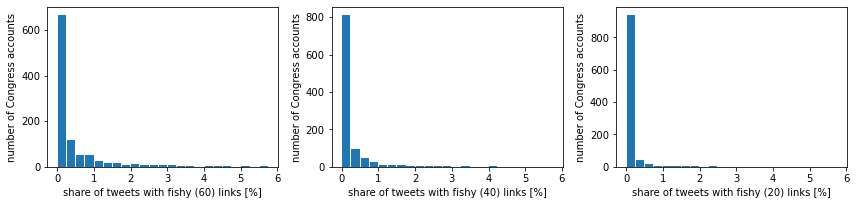

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, col, add in zip(axes.flatten(), 
                        ["share", "share_40", "share_20"],
                        ["(60)", "(40)", "(20)"]):
    ax.hist(fishy_user_count[col] * 100, 
            bins=np.arange(0, 6, 0.25), rwidth=0.9)
    ax.set_xlabel(f"share of tweets with fishy {add} links [%]")
    ax.set_ylabel("number of Congress accounts")
fig.tight_layout()

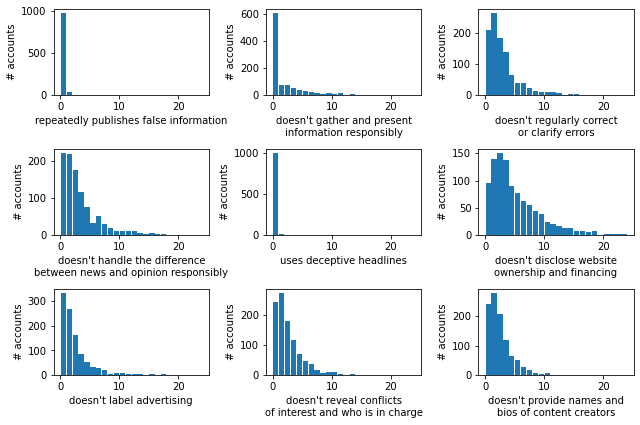

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(9, 6))
for ax, col in zip(axes.flatten(), nutrition_categories.values()):
    ax.hist(fishy_user_count[f"{col}_share"] * 100, 
            bins=np.arange(0, 25, 1), rwidth=0.9)
    ax.set_xlabel(nut_cat_dict[col])
    ax.set_ylabel("# accounts")
fig.tight_layout()

In [28]:
# flatten the hierarchical indices
fishy_user_count = fishy_user_count.reset_index()
fishy_user_count.columns = ['_'.join(col).strip("_") \
                            for col in fishy_user_count.columns.values]

In [29]:
fishy_user_count.head(2)

,author_id,fishy_sum,fishy_count,fishy_40_sum,fishy_40_count,fishy_20_sum,fishy_20_count,C_0_sum,C_0_count,C_1_sum,...,share_20,C_0_share,C_1_share,C_2_share,C_3_share,C_4_share,C_5_share,C_6_share,C_7_share,C_8_share
0,1009269193,0.0,1578,0.0,1578,0.0,1578,0.0,1558,1.0,...,0.0,0.0,0.000642,0.031451,0.003211,0.0,0.047497,0.007973,0.012195,0.014763
1,1011053278304591872,0.0,15,0.0,15,0.0,15,0.0,15,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.066667


## Add party affiliation to the mix

In [30]:
# author IDs have become converted to floats / integers and lost the last 4
# digits. We have a list of the correct IDs stored as strings and use it to
# match the corrupted IDs back to the correct ones based on the first 13 digits
# of the IDs

ids = np.loadtxt(join(src, "correct_author_ids.txt"))
ids = pd.DataFrame({"id":ids}).sort_values(by="id")
ids["id"] = ids["id"].astype(int).astype(str)
partial_ids = ids[ids["id"].apply(lambda x: len(x) >=14)].copy()
partial_ids["id_part"] = partial_ids["id"].apply(lambda x: x[0:13])
partial_ids = {row["id_part"]:row["id"] for i, row in partial_ids.iterrows()}

def match_id(old_id):
    if len(old_id) > 16:
        id_part = old_id[0:13]
        if id_part in partial_ids.keys():
            correct_id = partial_ids[id_part]
            return correct_id
    return old_id

## Make a user data frame

In [31]:
# load party affiliation, strip " used to ensure author_ids are stored as
# strings and not numbers
party_affiliation = pd.read_csv(join(src, "party_affiliations_complete.csv"))
party_affiliation["author_id"] = party_affiliation["author_id"]\
    .apply(lambda x: x.replace('"', ''))

party_affiliation["author_id"] = party_affiliation["author_id"].apply(match_id)
fishy_user_count["author_id"] = fishy_user_count["author_id"].apply(match_id)

# merge fishy link information and information about party affiliation
user_df = pd.merge(
    fishy_user_count, 
    party_affiliation, 
    how="left", 
    left_on="author_id",
    right_on="author_id"
).copy()

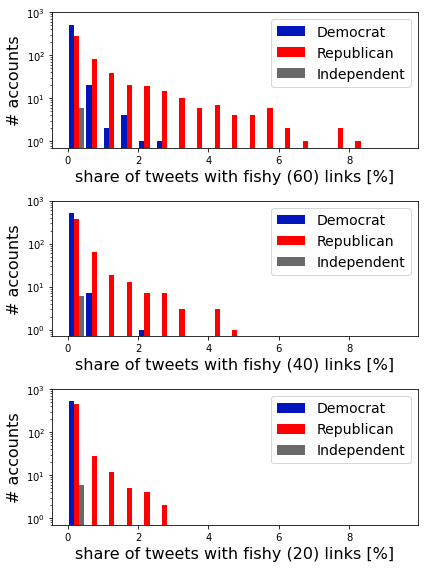

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ind = user_df[user_df["party"] == "Independent"]

for ax, col, add in zip(axes.flatten(), ["share", "share_40", "share_20"],
                        ["(60)", "(40)", "(20)"]):
    ax.hist([dem[col] * 100, rep[col] * 100, ind[col] * 100], 
            bins=np.arange(0, 10, 0.5), rwidth=0.9, 
            label=["Democrat", "Republican", "Independent"],
            color=[demblue, repred, indgrey])
    ax.set_xlabel(f"share of tweets with fishy {add} links [%]",
                  fontsize=ax_label_fontsize)
    ax.set_ylabel("# accounts", fontsize=ax_label_fontsize)
    ax.legend(fontsize=leg_label_fontsize)
    ax.set_ylim(0.7, 1e3)
    ax.set_yscale('log')
fig.tight_layout()
plt.savefig("../../plots/fishy_share.pdf")

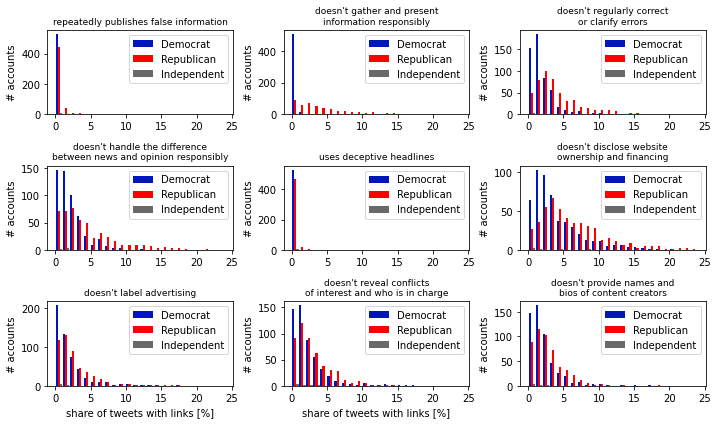

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(10, 6))
for ax, col, i in zip(axes.flatten(),
                      nutrition_categories.values(),
                      range(len(axes.flatten()))):
    ax.hist([dem[f"{col}_share"] * 100,
             rep[f"{col}_share"] * 100,
             ind[f"{col}_share"] * 100], 
            bins=np.arange(0, 25, 1), rwidth=0.9,
            label=["Democrat", "Republican", "Independent"],
            color=[demblue, repred, indgrey])
    ax.set_title(nut_cat_dict[col], fontsize=9)
    if i in [6, 7]:
        ax.set_xlabel("share of tweets with links [%]")
    ax.set_ylabel("# accounts")
    ax.legend()
fig.tight_layout()
plt.savefig("../../plots/nutrition_label_share.pdf")

In [34]:
all_tweets[all_tweets["fishy"] == 1]["Domain"].value_counts()[0:10]

breitbart.com           2403
thefederalist.com        703
newsmax.com              638
lifenews.com             341
theepochtimes.com        220
redstate.com             198
hannity.com              161
dailykos.com             158
oann.com                 108
thenationalpulse.com      91
Name: Domain, dtype: int64

In [35]:
all_tweets[all_tweets["fishy_40"] == 1]["Domain"].value_counts()[0:10]

thefederalist.com       703
newsmax.com             638
lifenews.com            341
hannity.com             161
dailykos.com            158
oann.com                108
thenationalpulse.com     91
thegatewaypundit.com     45
thehayride.com           40
revolver.news            39
Name: Domain, dtype: int64

In [36]:
all_tweets[all_tweets["fishy_20"] == 1]["Domain"].value_counts()[0:10]

thefederalist.com       703
oann.com                108
thenationalpulse.com     91
lifesitenews.com         39
revolver.news            39
wnd.com                  27
warroom.org              24
zerohedge.com            20
americanthinker.com      15
rushlimbaugh.com         13
Name: Domain, dtype: int64

## Add ideology scores

In [37]:
fname = "govtrack-stats-{}-{}-ideology.csv"
scores = pd.DataFrame()
for year in range(2013, 2021):
    for chamber in ["house", "senate"]:
        tmp = pd.read_csv(join(src, "ideology_scores",
                               fname.format(year, chamber)))
        tmp["year"] = year
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("b'", ""))
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("'", "").lower())
        scores = pd.concat([scores, tmp])

In [38]:
counts = scores["name"].value_counts()
# a single politician can have at maximum 8 entries for 8 different years
# 2013 to 2020
unique_names = list(counts[counts <= 8].index)

unique_scores = scores[scores["name"].isin(unique_names)]\
    .sort_values(by="year", ascending=False)\
    .drop_duplicates(subset=["name"])\
    .set_index("name")
unique_names = list(set(unique_scores.index))

def match_score(account_name):
    if account_name == account_name:
        account_name = set(account_name.lower().split(" "))
        for name in unique_names:
            if name in account_name:
                return unique_scores.loc[name]["id"]
    else:
        return np.nan
    
user_df["ideology_score_id"] = user_df["name"].apply(match_score)

In [39]:
# add hand-matched missing scores
missing_scores = pd.read_csv(join(src, "missing_scores.csv"))
missing_scores = {row["handle"]:row["ideology_score_id"] \
                  for i, row in missing_scores.iterrows()}

# merge on the handle since this seems to be the most consistent index between
# the two datasets
user_df = user_df.set_index("handle")
for handle, score_id in missing_scores.items():
    user_df.loc[handle, "ideology_score_id"] = score_id
    
user_df = user_df.reset_index()

### Ideology score exploration

In [40]:
scores = pd.merge(scores, user_df[["party", "handle", "author_id", "ideology_score_id"]].drop_duplicates(subset=["ideology_score_id"]),
                  how="left", left_on="id", right_on="ideology_score_id")

In [41]:
scores = scores.sort_values(by=["handle", "year"])

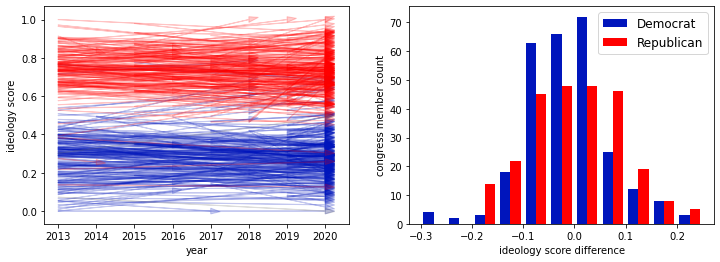

In [42]:
subset = scores.dropna(subset=["party"])
subset = subset.set_index("handle")
dem = subset[subset["party"] == "Democrat"]
rep = subset[subset["party"] == "Republican"]
ind = subset[subset["party"] == "Independent"]

diffs = pd.DataFrame()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
for dataset, color, party in zip([dem, rep, ind],
                                 [demblue, repred, indgrey],
                                 ["Democrat", "Republican", "Independent"]): 
    for handle in dataset.index.unique():
        user_data = dataset.loc[handle]
        if type(user_data) != pd.core.series.Series:
            x1 = user_data.iloc[0]["year"]
            x2 = user_data.iloc[-1]["year"] - x1
            y1 = user_data.iloc[0]["ideology"]
            y2 = user_data.iloc[-1]["ideology"] - y1
            
            diffs = diffs.append({
                "party":party,
                "ideology_difference":y2
            }, ignore_index=True)

        ax.arrow(x1, y1, x2, y2, color=color, alpha=0.2, 
                 width=0.001, head_width=0.03, head_length=0.25)
ax.set_ylabel("ideology score")
ax.set_xlabel("year")
        
ax = axes[1]
dem = diffs[diffs["party"] == "Democrat"]
rep = diffs[diffs["party"] == "Republican"]
ind = diffs[diffs["party"] == "Independent"]

ax.hist([dem["ideology_difference"], rep["ideology_difference"]],
        color=[demblue, repred], bins=np.arange(-0.3, 0.3, 0.05),
        label=["Democrat", "Republican"])
ax.set_ylabel("congress member count")
ax.set_xlabel("ideology score difference")
ax.legend(fontsize=12)

plt.savefig("../../plots/ideology_scores.png",
            bbox_inches="tight", facecolor="white")

In [43]:
diffs.groupby("party").agg("mean")

,ideology_difference
party,
Democrat,-0.007765
Independent,0.057141
Republican,0.001407


In [44]:
# for many accounts, there is more than one ideology score since they were 
# active over many years. We calculate the mean, std and count of the ideology
# score for each user and add this information to the user_df
scores_agg = scores[["id", "ideology"]]\
    .groupby("id")\
    .agg(["mean", "std", "count"])
scores_agg = scores_agg.reset_index()
scores_agg.columns = ['_'.join(col).strip("_") \
                            for col in scores_agg.columns.values]

user_df = user_df.merge(scores_agg, how="left", 
                      left_on="ideology_score_id", right_on="id")

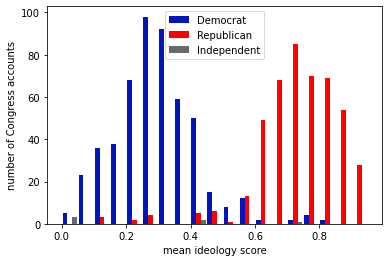

In [45]:
fig, ax = plt.subplots()
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ind = user_df[user_df["party"] == "Independent"]
ax.hist([dem["ideology_mean"], rep["ideology_mean"], ind["ideology_mean"]], 
        bins=np.arange(0, 1, 0.05), rwidth=0.9, 
        label=["Democrat", "Republican", "Independent"],
        color=[demblue, repred, indgrey])
ax.set_xlabel("mean ideology score")
ax.set_ylabel("number of Congress accounts")
ax.legend()
plt.savefig("../../plots/ideology_scores.pdf")

In [46]:
congress_twitter_handles = pd.read_csv(join(src, "US_politician_twitter_accounts", "clean", "congress-member-twitter-handles_114-117.csv"))
congress_twitter_handles = congress_twitter_handles\
    .sort_values(by="congress", ascending=False)\
    .drop_duplicates(subset="handle")\
    .reset_index(drop=True)

In [47]:
user_df = pd.merge(user_df, congress_twitter_handles, how="left", left_on="handle", right_on="handle")

/tmp/ipykernel_21558/2739250007.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dem_active = subsubset[(subsubset["party"] == "Democrat") & (subset["congress"] == 117)]
/tmp/ipykernel_21558/2739250007.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rep_active = subsubset[(subsubset["party"] == "Republican") & (subset["congress"] == 117)]
/tmp/ipykernel_21558/2739250007.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ind_active = subsubset[(subsubset["party"] == "Independent") & (subset["congress"] == 117)]
/tmp/ipykernel_21558/2739250007.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dem_inactive = subsubset[(subsubset["party"] == "Democrat") & (subset["congress"] != 117)]
/tmp/ipykernel_21558/2739250007.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rep_inactive = subsubset[(subsubset["party"] == "Rep

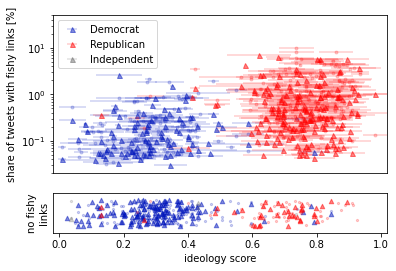

In [48]:
# share = cutoff @ NewsGuard < 60 
# share_40 = cutoff @ NewsGuard < 40 
# share_20 = cutoff @ NewsGuard < 20 
fishy_col = "share"
cutoff = 60

fig = plt.figure()
gs = GridSpec(2, 1, height_ratios=[4, 1])
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

subset = user_df.dropna(subset=["ideology_mean", fishy_col])
dem_active = subset[(subset["party"] == "Democrat") & (subset["congress"] == 117)]
rep_active = subset[(subset["party"] == "Republican") & (subset["congress"] == 117)]
ind_active = subset[(subset["party"] == "Independent") & (subset["congress"] == 117)]
dem_inactive = subset[(subset["party"] == "Democrat") & (subset["congress"] != 117)]
rep_inactive = subset[(subset["party"] == "Republican") & (subset["congress"] != 117)]
ind_inactive = subset[(subset["party"] == "Independent") & (subset["congress"] != 117)]

stuff = ax.errorbar(dem_active["ideology_mean"], dem_active[fishy_col] * 100, fmt='^',
           xerr=dem_active["ideology_std"], color=demblue,
           label="Democrat", alpha=0.5, ms=5)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]
stuff = ax.errorbar(dem_inactive["ideology_mean"], dem_inactive[fishy_col] * 100, fmt='o',
           xerr=dem_inactive["ideology_std"], color=demblue, alpha=0.2, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

stuff = ax.errorbar(rep_active["ideology_mean"], rep_active[fishy_col] * 100, fmt='^',
           xerr=rep_active["ideology_std"], color=repred,
           label="Republican", alpha=0.5, ms=5)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]
stuff = ax.errorbar(rep_inactive["ideology_mean"], rep_inactive[fishy_col] * 100, fmt='o',
           xerr=rep_inactive["ideology_std"], color=repred, alpha=0.2, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

stuff = ax.errorbar(ind_active["ideology_mean"], ind_active[fishy_col] * 100, fmt='^',
           xerr=ind_active["ideology_std"], color=indgrey,
           label="Independent", alpha=0.5, ms=5)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]
stuff = ax.errorbar(ind_inactive["ideology_mean"], ind_inactive[fishy_col] * 100, fmt='o',
           xerr=ind_inactive["ideology_std"], color=indgrey, alpha=0.2, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

ax.legend()
ax.set_yscale('log')
ax.set_ylabel("share of tweets with fishy links [%]")
ax.set_ylim(2e-2, 5e1)
ax.set_xticks([])
ax.set_xlim(-0.02, 1.02)

subsubset = subset[subset[fishy_col] == 0].copy()
subsubset[fishy_col] = subsubset[fishy_col]\
    .apply(lambda x: x + np.random.rand() * 2 - 1)

dem_active = subsubset[(subsubset["party"] == "Democrat") & (subset["congress"] == 117)]
rep_active = subsubset[(subsubset["party"] == "Republican") & (subset["congress"] == 117)]
ind_active = subsubset[(subsubset["party"] == "Independent") & (subset["congress"] == 117)]
dem_inactive = subsubset[(subsubset["party"] == "Democrat") & (subset["congress"] != 117)]
rep_inactive = subsubset[(subsubset["party"] == "Republican") & (subset["congress"] != 117)]
ind_inactive = subsubset[(subsubset["party"] == "Independent") & (subset["congress"] != 117)]

ax2.scatter(dem_active["ideology_mean"], dem_active[fishy_col], color=demblue, alpha=0.5,
            label="Democrat", s=20, marker="^")
ax2.scatter(dem_inactive["ideology_mean"], dem_inactive[fishy_col], color=demblue,
            alpha=0.2, s=5)

ax2.scatter(rep_active["ideology_mean"], rep_active[fishy_col], color=repred, alpha=0.5,
            label="Republican", s=20, marker="^")
ax2.scatter(rep_inactive["ideology_mean"], rep_inactive[fishy_col], color=repred,
            alpha=0.2, s=5)

ax2.scatter(ind_active["ideology_mean"], ind_active[fishy_col], color=indgrey, alpha=0.3,
            label="Independent", s=20, marker="^")
ax2.scatter(ind_inactive["ideology_mean"], ind_inactive[fishy_col], color=indgrey, 
            alpha=0.2, s=5)

ax2.set_yticks([])
ax2.set_xlabel("ideology score")
ax2.set_ylim([-1.5, 1.5])
ax2.set_xlim(-0.02, 1.02)
ax2.set_ylabel("no fishy\nlinks")
plt.savefig(f"../../plots/ideology_scores_and_fishy_links_cutoff_{cutoff}.pdf")
plt.savefig(f"../../plots/ideology_scores_and_fishy_links_cutoff_{cutoff}.png",
            bbox_inches="tight", facecolor="white")
plt.savefig(f"../../plots/ideology_scores_and_fishy_links_cutoff_{cutoff}.svg",
            bbox_inches="tight")

## Add truth seeking & belief speaking scores

In [57]:
src = "../../data/twitter"

In [47]:
! rsync -avze ssh jlasser@medea:/data/honesty/corpora/Twitter/combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_threshold_label.csv ../../data/twitter/combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_threshold_label.csv --progress

receiving incremental file list

sent 20 bytes  received 138 bytes  316.00 bytes/sec
total size is 667,007,968  speedup is 4,221,569.42


In [56]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_threshold_label.csv"
cols = ["id", "author_id", "belief_count", "truth_count", "understanding_count"]
honesty_tweets = pd.read_csv(join(src, fname), usecols=cols)

honesty_tweets["author_id"] = honesty_tweets["author_id"].apply(lambda x: x.replace('"', ''))
honesty_tweets["id"] = honesty_tweets["id"].apply(lambda x: x.replace('"', ''))
#honesty_tweets = honesty_tweets.rename(columns={
#    "belief_label":"belief",
#    "truth_label":"truth",
#    "understanding_label":"understanding"})

In [69]:
# 190650 unambiguous belief tweets
# 240302 unambiguous truth tweets
# 30613 ties with count > 0 including 607 ties with count > 1 and 13 ties with count > 2
honesty_tweets["belief"] = 0
honesty_tweets["truth"] = 0

# unambigous majority votes
honesty_tweets.loc[honesty_tweets[honesty_tweets["belief_count"] > honesty_tweets["truth_count"]].index, "belief"] = 1
honesty_tweets.loc[honesty_tweets[honesty_tweets["truth_count"] > honesty_tweets["belief_count"]].index, "truth"] = 1

# ties
honesty_tweets.loc[honesty_tweets[(honesty_tweets["truth_count"] == honesty_tweets["belief_count"]) &\
                                  (honesty_tweets["truth_count"] > 0)].index, "truth"] = 1
honesty_tweets.loc[honesty_tweets[(honesty_tweets["truth_count"] == honesty_tweets["belief_count"]) &\
                                  (honesty_tweets["truth_count"] > 0)].index, "belief"] = 1

### User-level analysis

In [72]:
honesty_label_count = honesty_tweets[["author_id", "belief", "truth"]]\
    .groupby("author_id")\
    .agg(["sum", "count"])

for col in ["belief", "truth"]:
    honesty_label_count[f"{col}_share"] = honesty_label_count[col]["sum"] / \
    honesty_label_count[col]["count"]
    
honesty_label_count.columns = ['_'.join(col).strip("_") \
                            for col in honesty_label_count.columns.values]
honesty_label_count = honesty_label_count.reset_index()
honesty_label_count["author_id"] = honesty_label_count["author_id"].apply(match_id)

In [73]:
user_df = user_df.merge(honesty_label_count, how="left", left_on="author_id", 
             right_on="author_id")

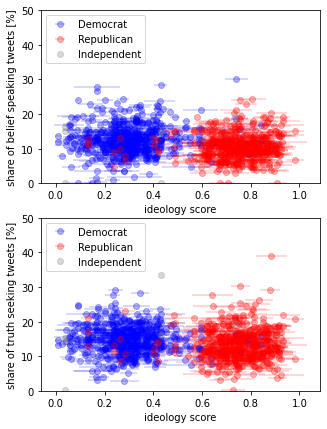

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ind = user_df[user_df["party"] == "Independent"]

for ax, col, label in zip(axes.flatten(), 
        ["belief_share", "truth_share"], ["belief speaking", "truth seeking"]):
    stuff = ax.errorbar(dem["ideology_mean"], dem[col] * 100 + 0.1, fmt='o',
               xerr=dem["ideology_std"], color='b',
               label="Democrat", alpha=0.3)
    markers, caps, bars = stuff
    [bar.set_alpha(0.2) for bar in bars]

    stuff = ax.errorbar(rep["ideology_mean"], rep[col] * 100 + 0.1, fmt='o',
               xerr=rep["ideology_std"], color='r', label="Republican", alpha=0.3)
    markers, caps, bars = stuff
    [bar.set_alpha(0.2) for bar in bars]

    stuff = ax.errorbar(ind["ideology_mean"], ind[col] * 100 + 0.1, fmt='o',
               color='grey', label="Independent", alpha=0.3)
    markers, caps, bars = stuff
    [bar.set_alpha(0.2) for bar in bars]

    ax.legend(loc=2)
    ax.set_xlabel("ideology score")
    ax.set_ylabel(f"share of {label} tweets [%]")
    ax.set_ylim(0, 50)
plt.savefig("../../plots/ideology_and_honesty_labels.pdf")

2 congress members have no truth seeking tweet


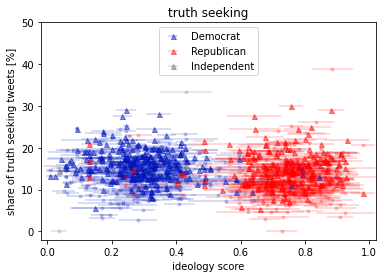

In [75]:
fig, ax = plt.subplots()
honesty_col = "truth_share"
label = "truth seeking"
print("{} congress members have no {} tweet".format(len(user_df[user_df[honesty_col] <= 0.01]), label))

subset = user_df.dropna(subset=["ideology_mean"]).copy()
subset.loc[subset[subset[honesty_col] == 0].index, honesty_col] = 0.001
dem_active = subset[(subset["party"] == "Democrat") & (subset["congress"] == 117)]
rep_active = subset[(subset["party"] == "Republican") & (subset["congress"] == 117)]
ind_active = subset[(subset["party"] == "Independent") & (subset["congress"] == 117)]
dem_inactive = subset[(subset["party"] == "Democrat") & (subset["congress"] != 117)]
rep_inactive = subset[(subset["party"] == "Republican") & (subset["congress"] != 117)]
ind_inactive = subset[(subset["party"] == "Independent") & (subset["congress"] != 117)]

stuff = ax.errorbar(dem_active["ideology_mean"], dem_active[honesty_col] * 100, fmt='^',
           xerr=dem_active["ideology_std"], color=demblue,
           label="Democrat", alpha=0.5, ms=5)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]
stuff = ax.errorbar(dem_inactive["ideology_mean"], dem_inactive[honesty_col] * 100, fmt='o',
           xerr=dem_inactive["ideology_std"], color=demblue, alpha=0.2, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

stuff = ax.errorbar(rep_active["ideology_mean"], rep_active[honesty_col] * 100, fmt='^',
           xerr=rep_active["ideology_std"], color=repred,
           label="Republican", alpha=0.5, ms=5)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]
stuff = ax.errorbar(rep_inactive["ideology_mean"], rep_inactive[honesty_col] * 100, fmt='o',
           xerr=rep_inactive["ideology_std"], color=repred, alpha=0.2, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

stuff = ax.errorbar(ind_active["ideology_mean"], ind_active[honesty_col] * 100, fmt='^',
           xerr=ind_active["ideology_std"], color=indgrey,
           label="Independent", alpha=0.5, ms=5)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]
stuff = ax.errorbar(ind_inactive["ideology_mean"], ind_inactive[honesty_col] * 100, fmt='o',
           xerr=ind_inactive["ideology_std"], color=indgrey, alpha=0.2, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

ax.legend()
#ax.set_yscale('log')
ax.set_ylabel(f"share of {label} tweets [%]")
ax.set_ylim(-2, 50)
ax.set_xlim(-0.02, 1.02)
ax.set_title(label)
ax.set_xlabel("ideology score")

plt.savefig(f"../../plots/ideology_scores_and_{label}.pdf")
plt.savefig(f"../../plots/ideology_scores_and_{label}.png",
            bbox_inches="tight", facecolor="white")

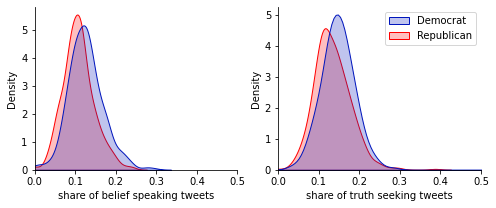

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
subset = user_df[user_df["party"].isin(["Democrat", "Republican"])]

for ax, col, label in zip(axes.flatten(), 
            ["belief_share", "truth_share"],
            ["belief speaking", "truth seeking"]):
    
    legend = False
    if col == "truth_share": legend = True
    sns.kdeplot(data=subset, x=col, hue="party", 
                palette=[demblue, repred], fill=True, ax=ax, legend=legend)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(f"share of {label} tweets")
    ax.set_xlim(0, 0.5)
    
axes[1].get_legend().set_title("")
plt.savefig("../../plots/honesty_component_marginal_distributions.png",
            bbox_inches="tight", facecolor="white")
plt.savefig("../../plots/honesty_component_marginal_distributions.pdf",
            bbox_inches="tight", facecolor="white")
plt.savefig("../../plots/honesty_component_marginal_distributions.svg",
            bbox_inches="tight")

In [ ]:
# redo for last 4 years & first 4 years

### Tweet-level analysis

In [77]:
len(honesty_tweets)

1824800

In [78]:
len(all_tweets)

2888528

In [79]:
original_tweets = all_tweets[all_tweets["retweeted"] == False]#.drop_duplicates(subset=["id"])

In [80]:
len(original_tweets)

2324378

In [81]:
tweet_df = pd.merge(honesty_tweets[["id", "belief", "truth"]], 
         original_tweets, how="right", left_on="id", right_on="id")
len(tweet_df)

2324378

In [82]:
tweet_df["neutral"] = 0
tweet_df.loc[tweet_df[tweet_df[["belief", "truth"]]\
                      .sum(axis=1) == 0].index, "neutral"] = 1

In [83]:
tweets_with_urls = tweet_df[tweet_df["has_url"] == True]
len(tweets_with_urls)

1787962

In [84]:
agg = tweets_with_urls[["fishy"] + ["belief", "truth", "neutral"]]\
                .groupby("fishy").agg(sum)

In [85]:
agg

,belief,truth,neutral
fishy,,,
0.0,35064.0,45226.0,232975
1.0,632.0,829.0,4335


In [86]:
tweets_with_urls[["belief", "truth"]].sum(axis=1).value_counts()

0.0    1393567
1.0     368553
2.0      25842
dtype: int64

In [87]:
tweets_with_urls = tweets_with_urls.merge(user_df[["author_id", "party"]],
                        how="left", left_on="author_id", right_on="author_id")
dem = tweets_with_urls[tweets_with_urls["party"] == "Democrat"]
rep = tweets_with_urls[tweets_with_urls["party"] == "Republican"]
datasets = {"all":tweets_with_urls, "democrat":dem, "republican":rep}

In [88]:
components = ["neutral", "belief", "truth"]
N_bootstrap = 100
cols = ["fishy", "fishy_40", "fishy_20"] + [f"C_{i}" for i in range(0, 9)]

In [89]:
def run_bootstrap(dataset):
    tmp = pd.DataFrame()
    tweet_sample = datasets[dataset].sample(len(datasets[dataset]), replace=True)
    row = {}
    for col in cols:
        agg = tweet_sample[[col] + components]\
                .groupby(col).agg(sum)
        res = agg.loc[1] / agg.loc[0]
        for comp in components:
            tmp = tmp.append({
                "misinfo_label":col,
                "honesty_component":comp,
                "percentage":res[comp]
            }, ignore_index=True)
            if comp != "neutral":
                tmp = tmp.append({
                        "misinfo_label":col,
                        "honesty_component":f"{comp}_diff",
                        "percentage":res[comp] - res["neutral"]
                    }, ignore_index=True)
            
    return tmp

In [90]:
bootstrap_results = pd.DataFrame()
pool = Pool(10)

for tmp in tqdm(pool.imap_unordered(
    func=run_bootstrap, 
    iterable=["all"] * N_bootstrap), 
    total=N_bootstrap):
        bootstrap_results = pd.concat([bootstrap_results, tmp])
bootstrap_results = bootstrap_results.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


In [91]:
bootstrap_result_dem = pd.DataFrame()
pool = Pool(10)

for tmp in tqdm(pool.imap_unordered(
    func=run_bootstrap, 
    iterable=["democrat"] * N_bootstrap), 
    total=N_bootstrap):
        bootstrap_result_dem = pd.concat([bootstrap_result_dem, tmp])
bootstrap_result_dem = bootstrap_result_dem.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.47it/s]


In [92]:
bootstrap_result_rep = pd.DataFrame()
pool = Pool(10)

for tmp in tqdm(pool.imap_unordered(
    func=run_bootstrap, 
    iterable=["republican"] * N_bootstrap), 
    total=N_bootstrap):
        bootstrap_result_rep = pd.concat([bootstrap_result_rep, tmp])
bootstrap_result_rep = bootstrap_result_rep.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.94it/s]


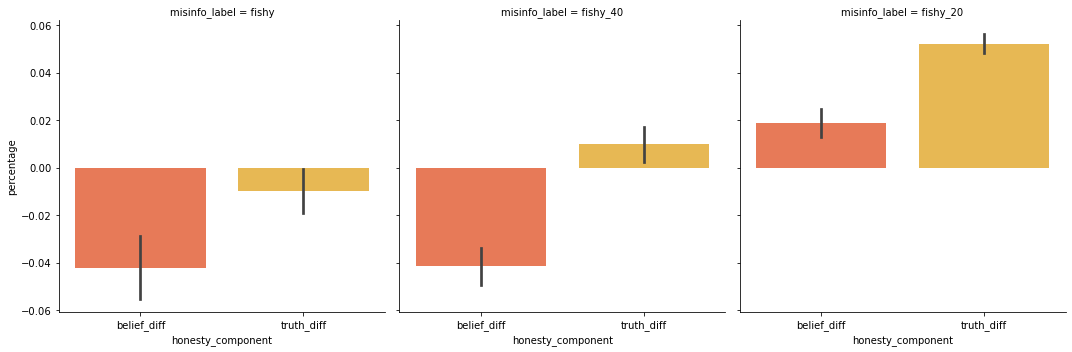

In [93]:
subset = bootstrap_results[bootstrap_results["honesty_component"]\
            .isin(["belief_diff", "truth_diff"])].copy()
subset["percentage"] = subset["percentage"] * 100

g = sns.catplot(
    x="honesty_component", y="percentage",  
    data=subset,
    col="misinfo_label", kind="bar", 
    col_order=["fishy", "fishy_40", "fishy_20"],
    palette = ["#ff6e40", "#ffc13b"])
#plt.savefig("../../plots/ideology_scores.png",
#            bbox_inches="tight", facecolor="white")

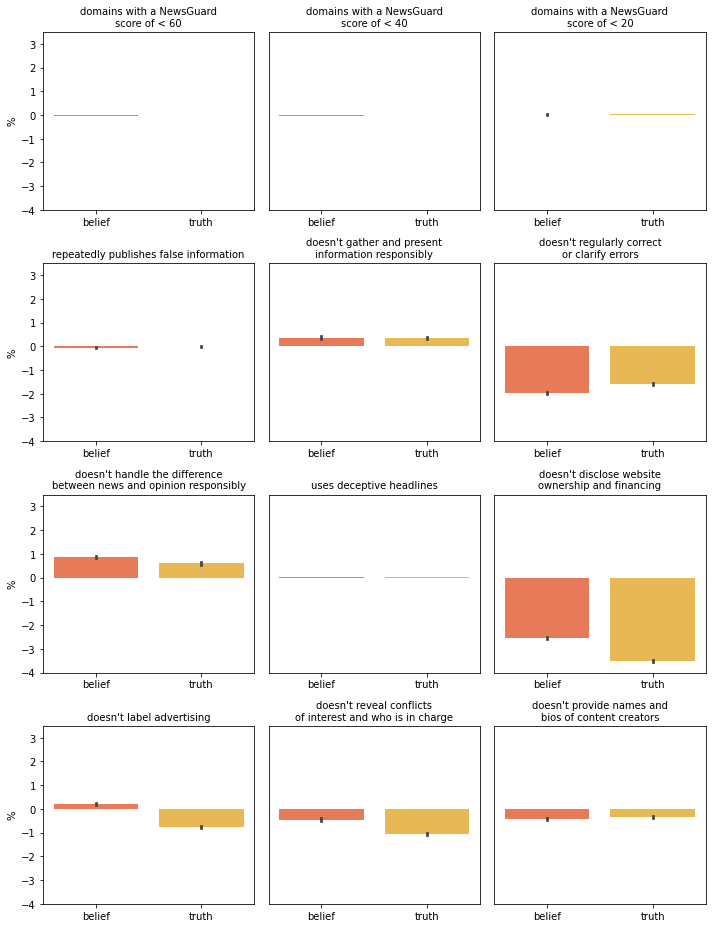

In [94]:
fig, axes = plt.subplots(4, 3, figsize=(10, 13))
for ax, mi, i in zip(axes.flatten(), cols, range(len(cols))):
    subset = bootstrap_results[(bootstrap_results["misinfo_label"] == mi) &
        (bootstrap_results["honesty_component"]\
         .isin(["belief_diff", "truth_diff"]))].copy()
    subset["percentage"] = subset["percentage"] * 100
    sns.barplot(x="honesty_component", y="percentage", data=subset, ax=ax,
                palette = ["#ff6e40", "#ffc13b"])
    ax.set_title(nut_cat_dict[mi], fontsize=10)
    ax.set_xlabel("")
    ax.set_ylim(-0.04 * 100, 0.035 * 100)
    ax.set_xticklabels(["belief", "truth"])
    if i in [1, 2, 4, 5, 7, 8, 10, 11]:
        ax.set_ylabel("")
        ax.set_yticks([])
    else:
        ax.set_ylabel("%")
    
fig.tight_layout()
plt.savefig("../../plots/honesty_components_misinfo_scores.png",
            bbox_inches="tight", facecolor="white")

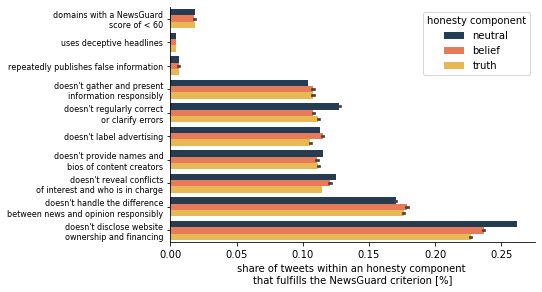

In [95]:
subset = bootstrap_results[bootstrap_results["honesty_component"].isin(["belief", "truth", "neutral"])]
order = ["fishy", "C_4", "C_0", "C_1", "C_2", "C_6", "C_8", "C_7",
         "C_3", "C_5"]
palette = ["#1e3d59", "#ff6e40", "#ffc13b"]
g = sns.catplot(x="percentage", y="misinfo_label",
                hue="honesty_component",
                data=subset, kind="bar",
                height=4, aspect=1.5, order=order,
                legend_out=False, palette=palette);
g.ax.set_ylabel("")
g.ax.set_xlabel("share of tweets within an honesty component \nthat fulfills the NewsGuard criterion [%]")
yticklabels = [nut_cat_dict[lab] for lab in order]
g.ax.set_yticklabels(yticklabels, fontsize=8)
g.ax.legend().set_title("honesty component")

for col, y in zip(order, range(0, 10)):
    col_data = bootstrap_results[bootstrap_results["misinfo_label"] == col]
    x = col_data[["honesty_component", "percentage"]]\
        .groupby("honesty_component")\
        .agg("mean").max()["percentage"]
    N = int(tweets_with_urls[col].sum())
    if col in order[-4:]:
        mod = -1.3
    else:
        mod = 0.2
    #g.ax.text(x + mod, y, f"N={N}", fontsize=8, color="grey")
fig.tight_layout()
plt.savefig("../../plots/fishy_links_and_honesty_components.png",
            bbox_inches="tight", facecolor="white")
plt.savefig("../../plots/fishy_links_and_honesty_components.svg",
            bbox_inches="tight")

In [97]:
bootstrap_result_dem["party"] = "dem"
bootstrap_result_rep["party"] = "rep"
bootstrap_results_party = pd.concat([bootstrap_result_dem,
                                     bootstrap_result_rep])\
    .reset_index(drop=True)
bootstrap_results_party["percentage"] = bootstrap_results_party["percentage"] * 100

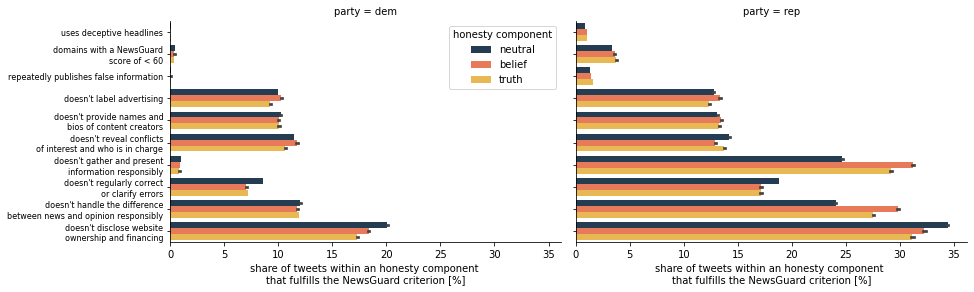

In [99]:
subset = bootstrap_results_party[bootstrap_results_party["honesty_component"].isin(["belief", "truth", "neutral"])]

order = ["C_4", "fishy", "C_0", "C_6", "C_8", "C_7",
         "C_1", "C_2", "C_3", "C_5"]
palette = ["#1e3d59", "#ff6e40", "#ffc13b"]
g = sns.catplot(x="percentage", y="misinfo_label",
                hue="honesty_component", col="party",
                data=subset, kind="bar",
                height=4, aspect=1.5, order=order,
                legend_out=False, palette=palette);
g.axes[0][0].set_ylabel("")
g.axes[0][0].set_ylabel("")
g.axes[0][0].set_xlabel("share of tweets within an honesty component \nthat fulfills the NewsGuard criterion [%]")
g.axes[0][1].set_xlabel("share of tweets within an honesty component \nthat fulfills the NewsGuard criterion [%]")
yticklabels = [nut_cat_dict[lab] for lab in order]
g.axes[0][0].set_yticklabels(yticklabels, fontsize=8)
g.axes[0][0].legend().set_title("honesty component")

fig.tight_layout()
plt.savefig("../../plots/fishy_links_and_honesty_components_partysplit.png",
            bbox_inches="tight", facecolor="white")

In [100]:
dem = tweets_with_urls[tweets_with_urls["party"] == "Democrat"]
rep = tweets_with_urls[tweets_with_urls["party"] == "Republican"]

In [102]:
belief_mean = dem[dem["belief"] == True]["Score"].mean()
belief_std = dem[dem["belief"] == True]["Score"].std()
truth_mean = dem[dem["truth"] == True]["Score"].mean()
truth_std = dem[dem["truth"] == True]["Score"].std()
print("belief: {:1.2f} +- {:1.2f}".format(belief_mean, belief_std))
print("truth: {:1.2f} +- {:1.2f}".format(truth_mean, truth_std))

belief: 94.92 +- 7.96
truth: 95.05 +- 7.98


In [103]:
belief_mean = rep[rep["belief"] == True]["Score"].mean()
belief_std = rep[rep["belief"] == True]["Score"].std()
truth_mean = rep[rep["truth"] == True]["Score"].mean()
truth_std = rep[rep["truth"] == True]["Score"].std()
print("belief: {:1.2f} +- {:1.2f}".format(belief_mean, belief_std))
print("truth: {:1.2f} +- {:1.2f}".format(truth_mean, truth_std))

belief: 86.73 +- 15.68
truth: 87.20 +- 15.76


### Timelines

In [110]:
tweets_with_urls["created_at"] = pd.to_datetime(tweets_with_urls["created_at"])
tweets_with_urls = tweets_with_urls.set_index("created_at")

In [111]:
# bootstrap coverage
N_bootstrap = 100
belief_bootstrap = pd.DataFrame()
for i in range(N_bootstrap):
    if i%10 == 0:
        print(i)
    tweet_sample = tweets_with_urls.sample(frac=1, replace=True)
    belief = tweet_sample[["belief", "party"]]\
        .groupby(by=[tweet_sample.index.year, tweet_sample.index.month, "party"])\
        .agg(["sum", "count"])

    belief.index.set_names(["year", "month", "party"], inplace=True)
    belief = belief.reset_index()
    belief.columns = ["year", "month", "party", "belief_sum", "belief_count"]
    belief["belief_share"] = belief["belief_sum"] / belief["belief_count"]
    belief["run"] = i
    belief_bootstrap = pd.concat([belief_bootstrap, belief])

0
10
20
30
40
50
60
70
80
90


In [112]:
belief = belief_bootstrap[["year", "month", "belief_share", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
belief = belief.reset_index()
belief.columns = ["year", "month", "party", "belief_mean", "belief_std"]

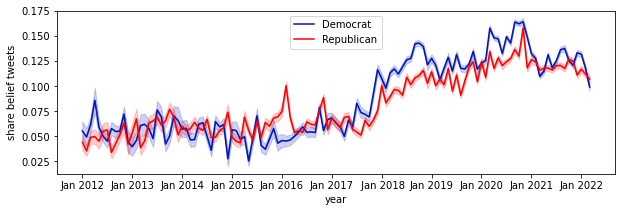

In [113]:
fig, ax = plt.subplots(figsize=(10, 3))
cutoff = 2011
dem = belief[(belief["year"] > cutoff) & (belief["party"] == "Democrat")].copy()
rep = belief[(belief["year"] > cutoff) & (belief["party"] == "Republican")].copy()
ax.plot(range(len(dem)), dem["belief_mean"], color=demblue, label="Democrat")
ax.fill_between(range(len(dem)), 
                 dem["belief_mean"],
                 dem["belief_mean"] + dem["belief_std"],
                 color=demblue, alpha=0.2)
ax.fill_between(range(len(dem)), 
                 dem["belief_mean"],
                 dem["belief_mean"] - dem["belief_std"],
                 color=demblue, alpha=0.2)

ax.plot(range(len(rep)), rep["belief_mean"], color=repred, label="Republican")
ax.fill_between(range(len(dem)), 
                 rep["belief_mean"],
                 rep["belief_mean"] + rep["belief_std"],
                 color=repred, alpha=0.2)
ax.fill_between(range(len(rep)), 
                 rep["belief_mean"],
                 rep["belief_mean"] - rep["belief_std"],
                 color=repred, alpha=0.2)

ax.set_ylabel("share belief tweets")
ax.set_xlabel("year")
ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
ax.set_xticklabels(["Jan 2012", "Jan 2013", "Jan 2014", "Jan 2015",
                    "Jan 2016", "Jan 2017", " Jan 2018", "Jan 2019",
                    "Jan 2020", "Jan 2021", "Jan 2022"])
ax.legend(loc=9)
plt.savefig("../../plots/honesty_component_timeline.png",
            bbox_inches="tight", facecolor="white")

### Scatterplots

In [114]:
user_df["fishy_share"] = user_df["fishy_sum"] / user_df["fishy_count"]

Text(0.5, 0, 'share of fishy tweets')

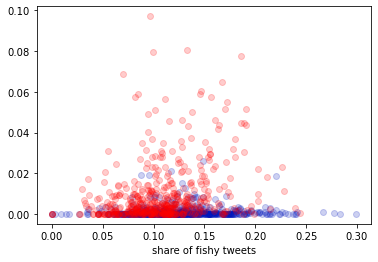

In [115]:
fig, ax = plt.subplots()
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ax.scatter(dem["belief_share"], dem["fishy_share"], 
           color=demblue, alpha=0.2)
ax.scatter(rep["belief_share"], rep["fishy_share"],
           color=repred, alpha=0.2)
ax.set_xlabel("share of belief tweets")
ax.set_xlabel("share of fishy tweets")

(0.0, 0.5)

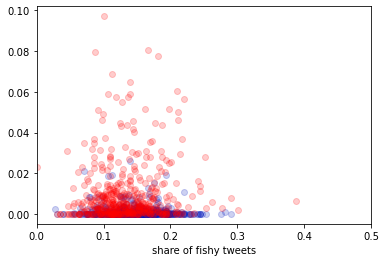

In [116]:
fig, ax = plt.subplots()
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ax.scatter(dem["truth_share"], dem["fishy_share"], 
           color=demblue, alpha=0.2)
ax.scatter(rep["truth_share"], rep["fishy_share"],
           color=repred, alpha=0.2)
ax.set_xlabel("share of truth tweets")
ax.set_xlabel("share of fishy tweets")
ax.set_xlim(0, 0.5)

In [118]:
neutral_count = honesty_tweets[honesty_tweets[["belief", "truth"]].sum(axis=1) == 0][["author_id", "id"]]\
    .groupby("author_id")\
    .agg("count")\
    .reset_index()\
    .rename(columns={"id":"neutral_count"})
neutral_count["author_id"] = neutral_count["author_id"].apply(match_id)

In [119]:
user_df = pd.merge(user_df, neutral_count, how="left", left_on="author_id",
         right_on="author_id").dropna(subset=["neutral_count"])

In [120]:
user_df["neutral_share"] = user_df["neutral_count"] / user_df["belief_count"]

In [130]:
from scipy.stats import spearmanr

In [133]:
N_bootstrap = 1000
bootstrap_honesty = pd.DataFrame()
for i in range(N_bootstrap):
    user_sample = user_df.sample(frac=1, replace=True)
    corr_belief = user_sample[["belief_share", "fishy_share"]].corr()\
        .loc["belief_share", "fishy_share"]
    corr_truth = user_sample[["truth_share", "fishy_share"]].corr()\
        .loc["truth_share", "fishy_share"]
    corr_neutral = user_sample[["neutral_share", "fishy_share"]].corr()\
        .loc["neutral_share", "fishy_share"] 
    
    sparman_corr_belief, spearman_pval_belief = \
        spearmanr(user_sample["belief_share"], user_sample["fishy_share"])
    sparman_corr_truth, spearman_pval_truth = \
        spearmanr(user_sample["truth_share"], user_sample["fishy_share"])
    sparman_corr_neutral, spearman_pval_neutral = \
        spearmanr(user_sample["neutral_share"], user_sample["fishy_share"])
    
    for corr, comp in zip([corr_belief, corr_truth, corr_neutral],
                          ["belief", "truth", "neutral"]):
        bootstrap_honesty = bootstrap_honesty.append({
            "val":corr,
            "val_type":"pearson_correlation",
            "component":comp
        }, ignore_index=True)
        
    for corr, comp in zip([sparman_corr_belief, sparman_corr_truth, sparman_corr_neutral],
                          ["belief", "truth", "neutral"]):
        bootstrap_honesty = bootstrap_honesty.append({
            "val":corr,
            "val_type":"spearman_correlation",
            "component":comp
        }, ignore_index=True)

    for pval, comp in zip([spearman_pval_belief, spearman_pval_truth, spearman_pval_neutral],
                          ["belief", "truth", "neutral"]):
        bootstrap_honesty = bootstrap_honesty.append({
            "val":pval,
            "val_type":"spearman_pval",
            "component":comp
        }, ignore_index=True)

In [141]:
N_bootstrap = 1000
bootstrap_honesty_log = pd.DataFrame()
for i in range(N_bootstrap):
    user_sample = user_df.sample(frac=1, replace=True).copy()
    user_sample["belief_share"] = np.log(user_sample["belief_share"] + 0.01)
    user_sample["truth_share"] = np.log(user_sample["truth_share"] + 0.01)
    
    corr_belief = user_sample[["belief_share", "fishy_share"]].corr()\
        .loc["belief_share", "fishy_share"]
    corr_truth = user_sample[["truth_share", "fishy_share"]].corr()\
        .loc["truth_share", "fishy_share"]
    corr_neutral = user_sample[["neutral_share", "fishy_share"]].corr()\
        .loc["neutral_share", "fishy_share"] 
    
    sparman_corr_belief, spearman_pval_belief = \
        spearmanr(user_sample["belief_share"], user_sample["fishy_share"])
    sparman_corr_truth, spearman_pval_truth = \
        spearmanr(user_sample["truth_share"], user_sample["fishy_share"])
    sparman_corr_neutral, spearman_pval_neutral = \
        spearmanr(user_sample["neutral_share"], user_sample["fishy_share"])
    
    for corr, comp in zip([corr_belief, corr_truth, corr_neutral],
                          ["belief", "truth", "neutral"]):
        bootstrap_honesty_log = bootstrap_honesty_log.append({
            "val":corr,
            "val_type":"pearson_correlation",
            "component":comp
        }, ignore_index=True)
        
    for corr, comp in zip([sparman_corr_belief, sparman_corr_truth, sparman_corr_neutral],
                          ["belief", "truth", "neutral"]):
        bootstrap_honesty_log = bootstrap_honesty_log.append({
            "val":corr,
            "val_type":"spearman_correlation",
            "component":comp
        }, ignore_index=True)

    for pval, comp in zip([spearman_pval_belief, spearman_pval_truth, spearman_pval_neutral],
                          ["belief", "truth", "neutral"]):
        bootstrap_honesty_log = bootstrap_honesty_log.append({
            "val":pval,
            "val_type":"spearman_pval",
            "component":comp
        }, ignore_index=True)

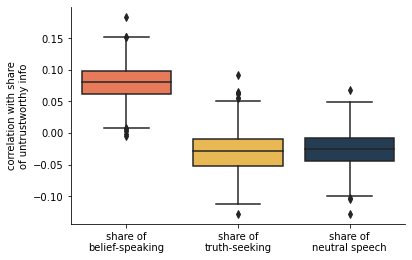

In [142]:
subset = bootstrap_honesty[bootstrap_honesty["val_type"] == "pearson_correlation"]
ax = sns.boxplot(x="component", y="val", data=subset,
                 palette=["#ff6e40", "#ffc13b", "#1e3d59"])
ax.set_ylabel("correlation with share\nof untrustworthy info")
ax.set_xlabel("")
ax.set_xticklabels(["share of\nbelief-speaking", "share of\ntruth-seeking",
                    "share of\nneutral speech"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("../../plots/honesty_component_fishy_user.svg",
            bbox_inches="tight", facecolor="white")
plt.savefig("../../plots/honesty_component_fishy_user.png",
            bbox_inches="tight", facecolor="white")

In [145]:
bootstrap_honesty["kind"] = "nolog"
bootstrap_honesty_log["kind"] = "log"

bootstrap_honesty = pd.concat([bootstrap_honesty, bootstrap_honesty_log])

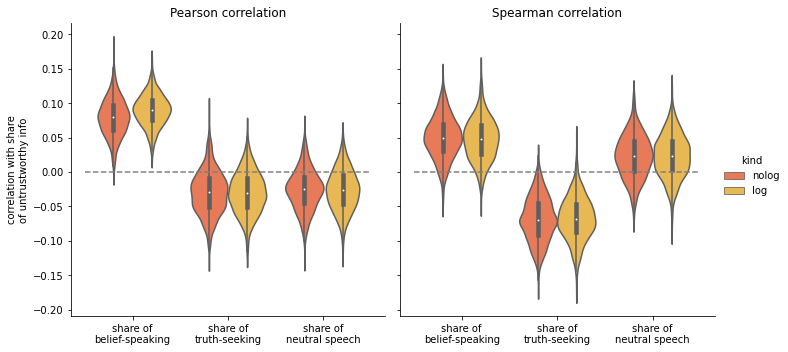

In [162]:
subset = bootstrap_honesty[bootstrap_honesty["val_type"].isin(["pearson_correlation","spearman_correlation"])]
g = sns.catplot(x="component", y="val", hue="kind", data=subset, col="val_type",
                 palette=["#ff6e40", "#ffc13b", "#1e3d59"], kind="violin")
g.axes[0][0].set_ylabel("correlation with share\nof untrustworthy info")
g.axes[0][0].set_xlabel("")
g.axes[0][1].set_xlabel("")
g.axes[0][0].set_title("Pearson correlation")
g.axes[0][1].set_title("Spearman correlation")
g.axes[0][0].set_xticklabels(["share of\nbelief-speaking", "share of\ntruth-seeking",
                    "share of\nneutral speech"])
g.axes[0][0].plot([-0.5, 2.5], [0, 0], "--", color="grey")
g.axes[0][1].plot([-0.5, 2.5], [0, 0], "--", color="grey")

In [ ]:
# share fishy link ~ log(# followers) + log(# tweets) + share belief + share truth + party + party X belief + party X truth

## NewsGuard score investigation

In [163]:
tweets_with_urls["NG_score"] = 0
tweets_with_urls.loc[tweets_with_urls["Score"].dropna().index, "NG_score"] = 1

### NewsGuard score timelines

In [164]:
# bootstrap coverage
N_bootstrap = 100
coverage_bootstrap = pd.DataFrame()
for i in range(N_bootstrap):
    if i%10 == 0:
        print(i)
    tweet_sample = tweets_with_urls.sample(frac=1, replace=True)
    coverage = tweet_sample[["NG_score", "party"]]\
        .groupby(by=[tweet_sample.index.year, tweet_sample.index.month, "party"])\
        .agg(["sum", "count"])

    coverage.index.set_names(["year", "month", "party"], inplace=True)
    coverage = coverage.reset_index()
    coverage.columns = ["year", "month", "party", "NG_score_sum", "NG_score_count"]
    coverage["NG_coverage"] = coverage["NG_score_sum"] / coverage["NG_score_count"]
    coverage["run"] = i
    coverage_bootstrap = pd.concat([coverage_bootstrap, coverage])

0
10
20
30
40
50
60
70
80
90


In [165]:
coverage = coverage_bootstrap[["year", "month", "NG_coverage", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
coverage = coverage.reset_index()
coverage.columns = ["year", "month", "party", "NG_coverage_mean", "NG_coverage_std"]

In [166]:
# bootstrap score
N_bootstrap = 100
score_bootstrap = pd.DataFrame()
for i in range(N_bootstrap):
    if i%10 == 0:
        print(i)
    tweet_sample = tweets_with_urls.sample(frac=1, replace=True)
    score = tweet_sample[["Score", "party"]]\
        .groupby(by=[tweet_sample.index.year, tweet_sample.index.month, "party"])\
        .agg(["mean", "std"])
    score.index.set_names(["year", "month", "party"], inplace=True)
    score = score.reset_index()
    score.columns = ["year", "month", "party", "NG_score_mean", "NG_score_std"]
    score["run"] = i
    score_bootstrap = pd.concat([score_bootstrap, score])

0
10
20
30
40
50
60
70
80
90


In [167]:
score = score_bootstrap[["year", "month", "party", "NG_score_mean"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
score = score.reset_index()
score.columns = ["year", "month", "party", "NG_score_mean", "NG_score_std"]

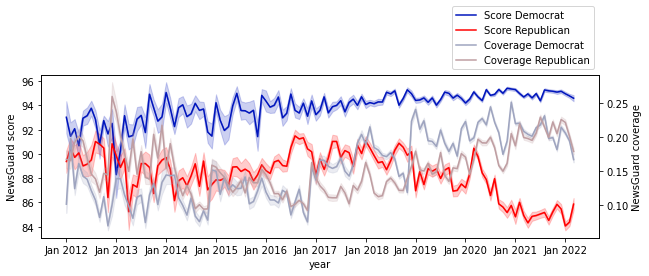

In [168]:
fig, ax = plt.subplots(figsize=(10, 3))
cutoff = 2011
dem = score[(score["year"] > cutoff) & (score["party"] == "Democrat")]
rep = score[(score["year"] > cutoff) & (score["party"] == "Republican")]
ln1 = ax.plot(range(len(dem)), dem["NG_score_mean"], color=demblue, label="Score Democrat")
ax.fill_between(range(len(dem)), 
                 dem["NG_score_mean"],
                 dem["NG_score_mean"] + dem["NG_score_std"],
                 color=demblue, alpha=0.2)
ax.fill_between(range(len(dem)), 
                 dem["NG_score_mean"],
                 dem["NG_score_mean"] - dem["NG_score_std"],
                 color=demblue, alpha=0.2)

ln2 = ax.plot(range(len(rep)), rep["NG_score_mean"], color=repred, label="Score Republican")
ax.fill_between(range(len(dem)), 
                 rep["NG_score_mean"],
                 rep["NG_score_mean"] + rep["NG_score_std"],
                 color=repred, alpha=0.2)
ax.fill_between(range(len(rep)), 
                 rep["NG_score_mean"],
                 rep["NG_score_mean"] - rep["NG_score_std"],
                 color=repred, alpha=0.2)

ax.set_ylabel("NewsGuard score")
ax.set_xlabel("year")
ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
ax.set_xticklabels(["Jan 2012", "Jan 2013", "Jan 2014", "Jan 2015",
                    "Jan 2016", "Jan 2017", " Jan 2018", "Jan 2019",
                    "Jan 2020", "Jan 2021", "Jan 2022"])

ax2 = ax.twinx()
dem = coverage[(coverage["year"] > cutoff) & (coverage["party"] == "Democrat")]
rep = coverage[(coverage["year"] > cutoff) & (coverage["party"] == "Republican")]
demgrey = "#9EA4BF"
repgrey = "#BF9EA2"

ln3 = ax2.plot(range(len(dem)), dem["NG_coverage_mean"], color=demgrey, label="Coverage Democrat")
ax2.fill_between(range(len(dem)), 
                 dem["NG_coverage_mean"],
                 dem["NG_coverage_mean"] + dem["NG_coverage_std"],
                 color=demgrey, alpha=0.2)
ax2.fill_between(range(len(dem)), 
                 dem["NG_coverage_mean"],
                 dem["NG_coverage_mean"] - dem["NG_coverage_std"],
                 color=demgrey, alpha=0.2)

ln4 = ax2.plot(range(len(rep)), rep["NG_coverage_mean"], color=repgrey, label="Coverage Republican")
ax2.fill_between(range(len(rep)), 
                 rep["NG_coverage_mean"],
                 rep["NG_coverage_mean"] + rep["NG_coverage_std"],
                 color=repgrey, alpha=0.2)
ax2.fill_between(range(len(rep)), 
                 rep["NG_coverage_mean"],
                 rep["NG_coverage_mean"] - rep["NG_coverage_std"],
                 color=repgrey, alpha=0.2)

ax2.set_ylabel("NewsGuard coverage")

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, bbox_to_anchor=[1, 1.45, 0, 0])
plt.savefig("../../plots/newsguard_timeline.png",
            bbox_inches="tight", facecolor="white")

### Fishy link timelines

In [315]:
# bootstrap fishy links
N_bootstrap = 100
fishy_bootstrap = pd.DataFrame()
for i in range(N_bootstrap):
    if i%10 == 0:
        print(i)
    tweet_sample = tweets_with_urls.sample(frac=1, replace=True)
    fishy = tweet_sample[["fishy", "party"]]\
        .groupby(by=[tweet_sample.index.year, tweet_sample.index.month, "party"])\
        .agg(["sum", "count"])
    fishy.index.set_names(["year", "month", "party"], inplace=True)
    fishy = fishy.reset_index()
    fishy.columns = ["year", "month", "party", "fishy_sum", "fishy_count"]
    fishy["run"] = i
    fishy["fishy_share"] = fishy["fishy_sum"] / fishy["fishy_count"]
    fishy_bootstrap = pd.concat([fishy_bootstrap, fishy])

0
10
20
30
40
50
60
70
80
90


In [316]:
fishy = fishy_bootstrap[["year", "month", "party", "fishy_share"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
fishy = fishy.reset_index()
fishy.columns = ["year", "month", "party", "fishy_mean", "fishy_std"]

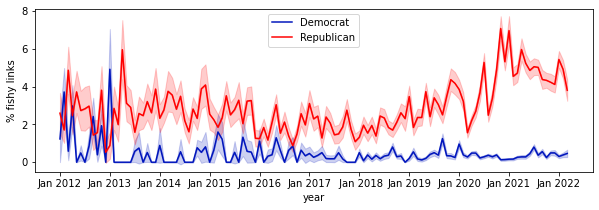

In [329]:
fig, ax = plt.subplots(figsize=(10, 3))
cutoff = 2011
dem = fishy[(fishy["year"] > cutoff) & (fishy["party"] == "Democrat")].copy()
rep = fishy[(fishy["year"] > cutoff) & (fishy["party"] == "Republican")].copy()
dem["fishy_mean"] = dem["fishy_mean"] * 100
dem["fishy_std"] = dem["fishy_std"] * 100
rep["fishy_mean"] = rep["fishy_mean"] * 100
rep["fishy_std"] = rep["fishy_std"] * 100
ax.plot(range(len(dem)), dem["fishy_mean"], color=demblue, label="Democrat")
ax.fill_between(range(len(dem)), 
                 dem["fishy_mean"],
                 dem["fishy_mean"] + dem["fishy_std"],
                 color=demblue, alpha=0.2)
ax.fill_between(range(len(dem)), 
                 dem["fishy_mean"],
                 dem["fishy_mean"] - dem["fishy_std"],
                 color=demblue, alpha=0.2)

ax.plot(range(len(rep)), rep["fishy_mean"], color=repred, label="Republican")
ax.fill_between(range(len(dem)), 
                 rep["fishy_mean"],
                 rep["fishy_mean"] + rep["fishy_std"],
                 color=repred, alpha=0.2)
ax.fill_between(range(len(rep)), 
                 rep["fishy_mean"],
                 rep["fishy_mean"] - rep["fishy_std"],
                 color=repred, alpha=0.2)

ax.set_ylabel("% fishy links")
ax.set_xlabel("year")
ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
ax.set_xticklabels(["Jan 2012", "Jan 2013", "Jan 2014", "Jan 2015",
                    "Jan 2016", "Jan 2017", " Jan 2018", "Jan 2019",
                    "Jan 2020", "Jan 2021", "Jan 2022"])
ax.legend(loc=9)
plt.savefig("../../plots/fishy_link_timeline.png",
            bbox_inches="tight", facecolor="white")

### Shared domain timelines

In [413]:
# bootstrap shared domains 
def run_bootstrap(i):
    tmp = pd.DataFrame()
    tweet_sample = tweets_with_urls.sample(frac=1, replace=True)
    for year in range(2010, 2023):
        #print(year)
        for month in range(1, 13):
            subset = tweet_sample[(tweet_sample.index.year == year) & \
                                  (tweet_sample.index.month == month)]
            domain_dem = set(subset[subset["party"] == "Democrat"]["Domain"])
            domain_rep = set(subset[subset["party"] == "Republican"]["Domain"])
            overlap = domain_dem.intersection(domain_rep)
            total = domain_dem.union(domain_rep)
            
            if len(total) > 0:
                tmp = tmp.append({
                    "year":year,
                    "month":month,
                    "run":i,
                    "domain_overlap":len(overlap),
                    "domain_overlap_percent":len(overlap) / len(total),
                    "domain_total":len(total),
                    "domain_dem":len(domain_dem),
                    "domain_dem_percent":len(domain_dem) / len(total),
                    "domain_rep":len(domain_rep),
                    "domain_rep_percent":len(domain_rep) / len(total)
                }, ignore_index=True)
    return tmp
            
domain_bootstrap = pd.DataFrame()
pool = Pool(10)
N_bootstrap = 10

for tmp in tqdm(pool.imap_unordered(
    func=run_bootstrap, 
    iterable=range(N_bootstrap)), 
    total=N_bootstrap):
        domain_bootstrap = pd.concat([domain_bootstrap, tmp])
domain_bootstrap = domain_bootstrap.reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.74s/it]


In [432]:
domain = domain_bootstrap[["year", "month", "domain_total",
                           "domain_overlap_percent",
                            "domain_dem_percent", "domain_rep_percent"]]\
    .groupby(["year", "month"])\
    .agg(["mean"])
domain = domain.reset_index()
domain.columns = ["year", "month", "domain_total_mean", "domain_overlap_percent_mean",
                  "domain_dem_percent_mean", "domain_rep_percent_mean"]

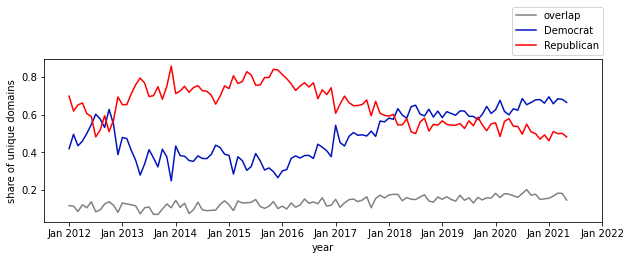

In [434]:
fig, ax = plt.subplots(figsize=(10, 3))
cutoff = 2011
subset = domain[(domain["year"] > cutoff)].copy()
subset = subset.iloc[0:-10]
ax.plot(range(len(subset)), subset["domain_overlap_percent_mean"], color="grey", label="overlap")
ax.plot(range(len(subset)), subset["domain_dem_percent_mean"], color=demblue, label="Democrat")
ax.plot(range(len(subset)), subset["domain_rep_percent_mean"], color=repred, label="Republican")

ax.set_ylabel("share of unique domains")
ax.set_xlabel("year")
ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
ax.set_xticklabels(["Jan 2012", "Jan 2013", "Jan 2014", "Jan 2015",
                    "Jan 2016", "Jan 2017", " Jan 2018", "Jan 2019",
                    "Jan 2020", "Jan 2021", "Jan 2022"])
ax.legend(loc=9, bbox_to_anchor=[0.92, 0, 0, 1.35])
plt.savefig("../../plots/domain_overlap.png",
            bbox_inches="tight", facecolor="white")

## Data exports

In [306]:
polifact_score = pd.read_csv("../../data/misinfo_score_politifact.csv")

In [311]:
len(set(user_df["handle"]).intersection(polifact_score["elite_account"]))

302

In [ ]:
user_df.to_csv(join(src, "US_politician_twitter_account_stats_2010-11-06_to_2022-03-16.csv"),
               index=False)

In [ ]:
all_tweets[all_tweets["fishy"] == 1].to_csv(join(src, "tweets_with_dodgy_links.csv"),
                                            index=False)

In [ ]:
tweets_with_urls.to_csv(join(src, "tweets_with_urls.csv"),
                        index=False)